In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Sample SQL queries

```sql
SELECT *
FROM movie_companies AS mc
INNER JOIN title AS tO N t.id = mc.movie_id
INNER JOIN movie_info_idx AS mi_idx
    ON t.id = mi_idx.movie_id
WHERE mi_idx.info_type_id = 113
    AND mc.company_type_id = 2
    AND t.production_year > 1880
    AND t.production_year < 1967
```

```sql
SELECT *
FROM movie_companies AS mc
INNER JOIN title AS tO N t.id = mc.movie_id
INNER JOIN movie_info_idx AS mi_idx
    ON t.id = mi_idx.movie_id
WHERE mi_idx.info_type_id = 113
    AND mc.company_type_id = 2
    AND t.production_year > 1880
    AND t.production_year < 1968
```

## Plots

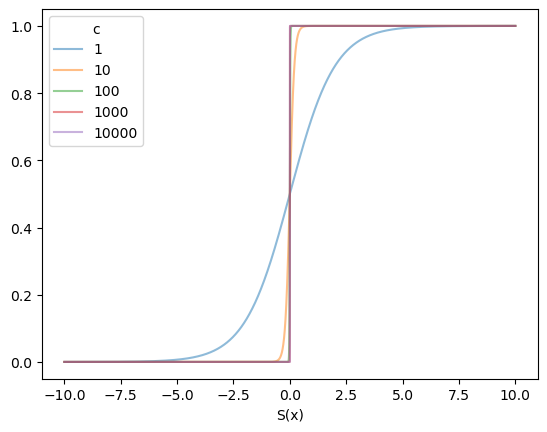

In [2]:
# plot a motivation figure for soft sign

fig, ax = plt.subplots(1, 1)
x_vals = np.linspace(-10, 10, 10001)

def stable_c_sigmoid(x, c):
    if x >= 0:
        return 1/(1 + np.exp(-1 * c * x))
    else:
        return np.exp(c * x)/(1 + np.exp(c * x))

for c in [1, 10, 100, 1000, 10000]:

    y_vals = [stable_c_sigmoid(x, c) for x in x_vals]
    ax.plot(x_vals, y_vals, label=str(c), alpha=0.5)

ax.legend(title="c")
plt.xlabel('x')
plt.xlabel('S(x)')
plt.savefig('figures/c_sigmoid_plot.pdf')

## load grid search results

In [3]:
gs_result = list()

gs_dir = os.path.join('logs', 'grid_search')
for sub_dir in os.listdir(gs_dir):
    full_dir_path = os.path.join(gs_dir, sub_dir)
    if os.path.isdir(full_dir_path):
        with open(os.path.join(full_dir_path, 'config.json'), "r") as fin:
            config_dict = json.load(fin)
        with open(os.path.join(full_dir_path, 'eval.json'), "r") as fin:
            eval_dict = json.load(fin)
        join = dict()
        for target in [config_dict, eval_dict]:
            for k, v in target.items():
                join[k] = v
        # add MonoM more stats
        monom_df = pd.read_csv(os.path.join(full_dir_path, 'test_monom.csv'))
        join['monom_std'] = np.std(monom_df.MonoM.values)
        join['monom_10'] = np.percentile(monom_df.MonoM.values, 10)
        join['monom_25'] = np.percentile(monom_df.MonoM.values, 25)
        join['monom_75'] = np.percentile(monom_df.MonoM.values, 75)
        join['monom_90'] = np.percentile(monom_df.MonoM.values, 90)
        # add Q-error more stats
        qerror_df = pd.read_csv(os.path.join(full_dir_path, 'test_qerror.csv'))
        join['qerror_std'] = np.std(qerror_df.qerror.values)
        join['timestamp'] = sub_dir
        gs_result.append(join)

gs_result = pd.DataFrame(gs_result)

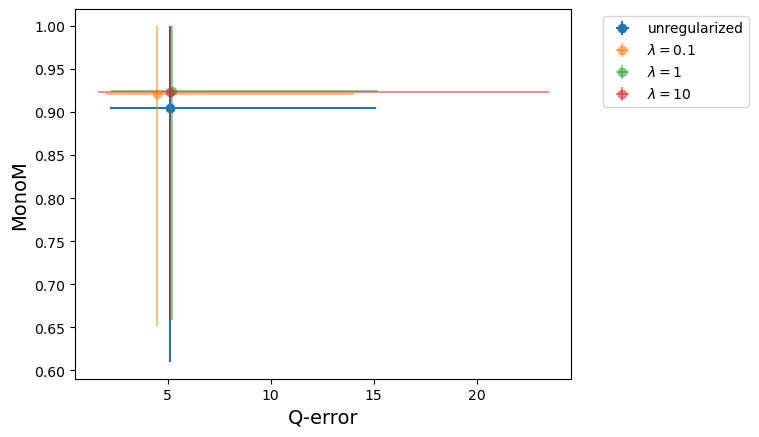

In [4]:
# scatter plot

fig, ax = plt.subplots(1, 1)

unregularized_df = gs_result[gs_result.lbda == 0.0]
regularized_df = gs_result[gs_result.lbda != 0.0]

# for unregularized results, plot the default configuration from the paper
unreg_selected_row = unregularized_df[unregularized_df.num_hidden_units == 256].iloc[0]
ax.errorbar(
    unreg_selected_row['qerror_median'], unreg_selected_row['monom_mean'],
    xerr=[
        [unreg_selected_row['qerror_median'] - unreg_selected_row['qerror_25']],
        [unreg_selected_row['qerror_75'] - unreg_selected_row['qerror_median']]
    ],
    yerr=[
        [min(unreg_selected_row['monom_std'], unreg_selected_row['monom_mean'])],
        [min(unreg_selected_row['monom_std'], 1 - unreg_selected_row['monom_mean'])]
    ],
    label='unregularized',
    fmt='o'
)

# for regularized results, plot 256 hidden units, and for each lambda = 0.1, 1, 10,
# plot the one with the best mean monom score
reg_selected_rows = dict()
for lbda in [0.1, 1, 10]:
    sub_df = regularized_df[(regularized_df.lbda == lbda) & (regularized_df.num_hidden_units == 256)]
    max_monom = np.amax(sub_df.monom_mean.values)
    selected_row = sub_df[sub_df.monom_mean == max_monom].iloc[0]
    reg_selected_rows[lbda] = selected_row
    ax.errorbar(
        selected_row['qerror_median'], selected_row['monom_mean'],
        xerr=[
            [selected_row['qerror_median'] - selected_row['qerror_25']],
            [selected_row['qerror_75'] - selected_row['qerror_median']]
        ],
        yerr=[
            [min(selected_row['monom_std'], selected_row['monom_mean'])],
            [min(selected_row['monom_std'], 1 - selected_row['monom_mean'])]
        ],
        label='$\lambda={}$'.format(lbda),
        fmt='o',
        alpha=0.5
    )

ax.set_xlabel('Q-error', fontsize=14)
ax.set_ylabel('MonoM', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.savefig('figures/overall_eval.pdf', bbox_inches='tight')

In [5]:
# compute some statistics
selected_df = pd.DataFrame([unreg_selected_row,] + [x for _, x in reg_selected_rows.items()])
selected_df[['lbda', 'qerror_median', 'qerror_25', 'qerror_75', 'monom_mean', 'monom_std']]

,lbda,qerror_median,qerror_25,qerror_75,monom_mean,monom_std
97,0.0,5.105335,2.192246,15.102321,0.904199,0.294318
78,0.1,4.466667,2.024563,14.025801,0.921282,0.269298
113,1.0,5.232400,2.270577,15.191966,0.924039,0.264935
22,10.0,5.129969,1.620143,23.488267,0.923659,0.265543


## Hyperparameter $\lambda$

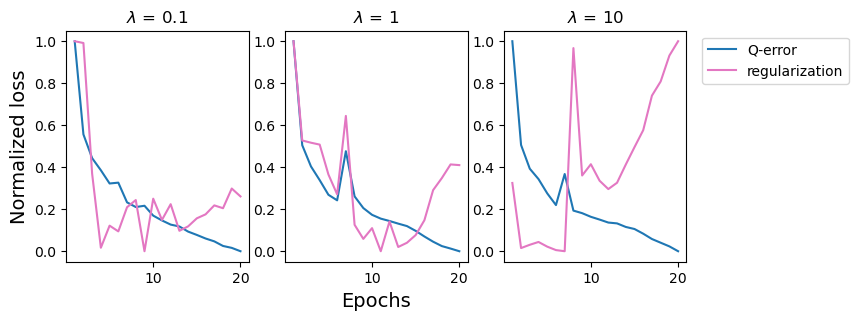

In [6]:
num_hidden_units = 256
soften = 10000
reg_dist_metric = 'jaccard'

fig = plt.figure(figsize=(8, 3))
ax_total = fig.add_subplot(111)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
axs = [ax1, ax2, ax3]

def normalize(arr):
    arr_min, arr_max = np.amin(arr), np.amax(arr)
    return (arr - arr_min) / (arr_max - arr_min)

lbdas = [0.1, 1, 10]
epoch_limit = 20
x_vals = np.linspace(1, epoch_limit, epoch_limit)
for ax, lbda in zip(axs, lbdas):
    row = gs_result[(gs_result.lbda == lbda) & (gs_result.soften == soften) & (gs_result.num_hidden_units == num_hidden_units) & (gs_result.reg_dist_metric == reg_dist_metric)].iloc[0]
    ts = row['timestamp']
    log_df = pd.read_csv(os.path.join('logs', 'grid_search', ts, 'train_log.csv'))
    q_loss = normalize(log_df.val_loss_q.values[0:epoch_limit])
    reg_loss = normalize(log_df.val_loss_reg.values[0:epoch_limit])

    ax.plot(x_vals, q_loss, label='Q-error', c='tab:blue')
    ax.plot(x_vals, reg_loss, label='regularization', c='tab:pink')

    ax.set_title('$\lambda$ = {}'.format(lbda))

    if lbda == 10:
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

ax_total.spines['top'].set_color('none')
ax_total.spines['bottom'].set_color('none')
ax_total.spines['left'].set_color('none')
ax_total.spines['right'].set_color('none')
ax_total.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax_total.set_xlabel('Epochs', fontsize=14)
ax_total.set_ylabel('Normalized loss', fontsize=14)

plt.savefig('figures/q_reg_loss.pdf', bbox_inches='tight')

## Plot train/validation loss for different choice of distance function

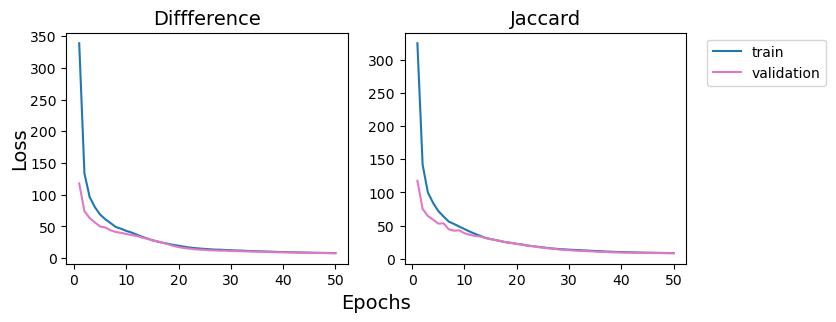

In [7]:
num_hidden_units = 256
soften = 10000
lbda = 0.1

diff_selected_row = gs_result[(gs_result.lbda == lbda) & (gs_result.soften == soften) & (gs_result.num_hidden_units == num_hidden_units) & (gs_result.reg_dist_metric == 'diff')].iloc[0]
jaccard_selected_row = gs_result[(gs_result.lbda == lbda) & (gs_result.soften == soften) & (gs_result.num_hidden_units == num_hidden_units) & (gs_result.reg_dist_metric == 'jaccard')].iloc[0]

fig = plt.figure(figsize=(8, 3))
ax_total = fig.add_subplot(111)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
axs = [ax1, ax2]
for ax, row in zip(axs, [diff_selected_row, jaccard_selected_row]):
    ts = row['timestamp']
    log_df = pd.read_csv(os.path.join('logs', 'grid_search', ts, 'train_log.csv'))
    train_loss = log_df.train_loss.values
    val_loss = log_df.val_loss.values
    x_vals = np.linspace(1, len(train_loss), len(train_loss))

    ax.plot(x_vals, train_loss, c='tab:blue', label='train')
    ax.plot(x_vals, val_loss, c='tab:pink', label='validation')

    if row['reg_dist_metric'] == 'jaccard':
        ax.set_title('Jaccard', fontsize=14)
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    else:
        ax.set_title('Diffference', fontsize=14)

ax_total.spines['top'].set_color('none')
ax_total.spines['bottom'].set_color('none')
ax_total.spines['left'].set_color('none')
ax_total.spines['right'].set_color('none')
ax_total.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax_total.set_xlabel('Epochs', fontsize=14)
ax_total.set_ylabel('Loss', fontsize=14)

plt.savefig('figures/train_val_loss.pdf', bbox_inches='tight')

In [8]:
# Get the best Q-error and MonoM scores for each distance

cols = ['lbda', 'qerror_median', 'monom_mean']
jaccard_df = gs_result[(gs_result.reg_dist_metric == 'jaccard') & (gs_result.lbda.isin((0.1, 0.5, 1, 3, 10)))][cols]
diff_df = gs_result[(gs_result.reg_dist_metric == 'diff') & (gs_result.lbda.isin((0.1, 0.5, 1, 3, 10)))][cols]

agg_dict = {'qerror_median': 'min', 'monom_mean': 'max'}
jaccard_grb = jaccard_df.groupby(by=['lbda']).agg(agg_dict)
diff_grb = diff_df.groupby(by=['lbda']).agg(agg_dict)

print(diff_grb)
print(jaccard_grb)

      qerror_median  monom_mean
lbda                           
0.1        3.909516    0.924328
0.5        4.489510    0.918866
1.0        4.028980    0.916660
3.0        4.223732    0.915570
10.0       3.419598    0.912905
      qerror_median  monom_mean
lbda                           
0.1        4.157818    0.921282
0.5        3.903503    0.919234
1.0        4.360392    0.924039
3.0        2.892273    0.917789
10.0       4.023294    0.923659


## Choice of c?

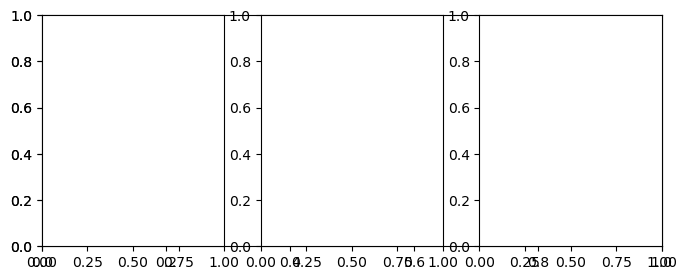

In [9]:
c_vals = [10, 100, 1000]
dist = 'jaccard'
hidden = 256
lbda = 0.1

fig = plt.figure(figsize=(8, 3))
ax_total = fig.add_subplot(111)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
axs = [ax1, ax2, ax3]

for c, ax in zip(c_vals, axs):
    row = gs_result[(gs_result.lbda == lbda) & (gs_result.soften == soften) & (gs_result.num_hidden_units == num_hidden_units) & (gs_result.reg_dist_metric == reg_dist_metric)].iloc[0]
    ts = row['timestamp']
    log_df = pd.read_csv(os.path.join('logs', 'grid_search', ts, 'train_log.csv'))

## training time analysis

In [15]:
lbda = 0.1
soften = 10000

hidden_units = [128, 256, 512]
distances = ['baseline', 'difference', 'jaccard']

result_dict = dict()
for hidden in hidden_units:
    baseline = gs_result[(gs_result.lbda == 0.0) & (gs_result.num_hidden_units == hidden)].iloc[0]
    diff = gs_result[(gs_result.lbda == lbda) & (gs_result.soften == soften) & (gs_result.num_hidden_units == hidden) & (gs_result.reg_dist_metric == 'diff')].iloc[0]
    jaccard = gs_result[(gs_result.lbda == lbda) & (gs_result.soften == soften) & (gs_result.num_hidden_units == hidden) & (gs_result.reg_dist_metric == 'jaccard')].iloc[0]

    baseline_log = pd.read_csv(os.path.join('logs/grid_search', baseline['timestamp'], "train_log.csv"))
    diff_log = pd.read_csv(os.path.join('logs/grid_search', diff['timestamp'], "train_log.csv"))
    jaccard_log = pd.read_csv(os.path.join('logs/grid_search', jaccard['timestamp'], "train_log.csv"))

    baseline_time = baseline_log.time.values
    diff_time = diff_log.time.values
    jaccard_time = jaccard_log.time.values

    result_dict[hidden] = (baseline_time, diff_time, jaccard_time)

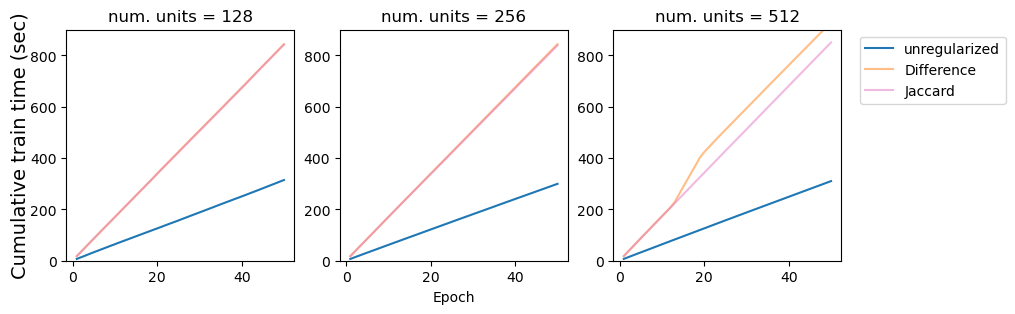

In [28]:
# plot CDFs
fig = plt.figure(figsize=(10, 3))
ax_total = fig.add_subplot(111)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
axs = [ax1, ax2, ax3]

x_vals = np.linspace(1, 50, 50)
for ax, hu in zip(axs, hidden_units):
    ax.set_title('num. units = {}'.format(hu))
    ax.plot(x_vals, np.cumsum(result_dict[hu][0]), label='unregularized', color='tab:blue')
    ax.plot(x_vals, np.cumsum(result_dict[hu][1]), label='Difference', color='tab:orange', alpha=0.5)
    ax.plot(x_vals, np.cumsum(result_dict[hu][2]), label='Jaccard', color='tab:pink', alpha=0.5)
    ax.set_ylim(0, 900)
    if hu == 512:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax_total.spines['top'].set_color('none')
ax_total.spines['bottom'].set_color('none')
ax_total.spines['left'].set_color('none')
ax_total.spines['right'].set_color('none')
ax_total.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax_total.set_ylabel("Cumulative train time (sec)", fontsize=14)
ax_total.set_xlabel("Epoch")

plt.savefig('figures/time_analysis.pdf')